<a href="https://colab.research.google.com/github/ugurcancakal/network_pytorch/blob/master/CNN_GPU_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using Convolutional Neural Networks in PyTorch

In [1]:
import os
import torch 
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">

## Exploring the data

In [2]:
# Download the dataset

dataset_url = 'http://files.fast.ai/data/cifar10.tgz'
download_url(dataset_url, '.')

In [3]:
# with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
#   tar.extractall(path='./data')

The dataset is extracted to the directory `data/cifar10`. It contains 2 folders `train` and `test`, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using `os.listdir`.

In [4]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir+'/train')
print(classes)

['test', 'train', 'labels.txt']
['dog', 'bird', 'frog', 'horse', 'cat', 'truck', 'airplane', 'ship', 'deer', 'automobile']


In [5]:
airplane_files = os.listdir(data_dir + '/train/airplane')
print('No of training examples of airplanes: ', len(airplane_files))
print(airplane_files[:5])

No of training examples of airplanes:  5000
['27954_airplane.png', '4270_airplane.png', '9287_airplane.png', '18864_airplane.png', '35373_airplane.png']


In [6]:
ship_test_files = os.listdir(data_dir + '/test/ship')
print('No of test examples of ships: ', len(ship_test_files))
print(ship_test_files[:5])

No of test examples of ships:  1000
['6486_ship.png', '5466_ship.png', '8075_ship.png', '3562_ship.png', '7833_ship.png']


In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [8]:
dataset = ImageFolder(data_dir+'/train', transform = ToTensor())

In [9]:
img,label = dataset[0]
print(img.shape, label)
print(img)
print(dataset.classes)

torch.Size([3, 32, 32]) 0
tensor([[[0.8588, 0.8588, 0.8627,  ..., 0.8510, 0.8471, 0.8392],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         ...,
         [0.8980, 0.9020, 0.9098,  ..., 0.8980, 0.8902, 0.8863],
         [0.8471, 0.8549, 0.8706,  ..., 0.8980, 0.8902, 0.8824],
         [0.7608, 0.7490, 0.7725,  ..., 0.8980, 0.8902, 0.8824]],

        [[0.9333, 0.9333, 0.9373,  ..., 0.9176, 0.9137, 0.9059],
         [0.9412, 0.9412, 0.9490,  ..., 0.9294, 0.9216, 0.9137],
         [0.9412, 0.9412, 0.9490,  ..., 0.9255, 0.9216, 0.9137],
         ...,
         [0.9608, 0.9569, 0.9569,  ..., 0.9412, 0.9412, 0.9412],
         [0.9020, 0.9098, 0.9255,  ..., 0.9412, 0.9412, 0.9373],
         [0.8157, 0.8039, 0.8275,  ..., 0.9412, 0.9412, 0.9373]],

        [[0.9608, 0.9608, 0.9647,  ..., 0.9490, 0.9412, 0.9412],
         [0.9686, 0.9686, 0.9765,  ..., 0.9608, 0.9529, 0.9490],
         [0.9686, 0.9686, 0.9765

In [10]:
import matplotlib.pyplot as plt

def show_example(img,label):
  print('Label: {}'.format(dataset.classes[label]))
  plt.imshow(img.permute(1,2,0))
  # plt waits the last dimension as the channel

Label: cat


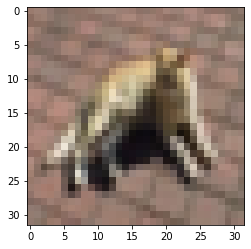

In [11]:
show_example(*dataset[18523])

In [12]:
import numpy as np

def split_indices(n ,val_pct=.1, seed=99):
  # Determine size of validation set
  n_val = int(val_pct*n)
  # Set the random seed
  np.random.seed(seed)
  # Create the random permutation of 0 to n-1
  idxs = np.random.permutation(n)
  # First n_val indices for validation
  return idxs[n_val:], idxs[:n_val]

In [13]:
val_pct = .2
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_pct, rand_seed)
print(len(train_indices), len(val_indices))
print('Sample validation indices', val_indices[:10])

40000 10000
Sample validation indices [33553  9427   199 12447 39489 42724 10822 49498  4144 36958]


In [14]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

batch_size = 100

In [15]:
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                      batch_size,
                      sampler = train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                    batch_size,
                    sampler = val_sampler)


In [16]:
from torchvision.utils import make_grid

def show_batch(dl):
  gridsize = int(np.sqrt(batch_size))
  for images, labels in dl:
    fig,ax = plt.subplots(figsize = (gridsize,gridsize))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, gridsize).permute(1,2,0))
    break

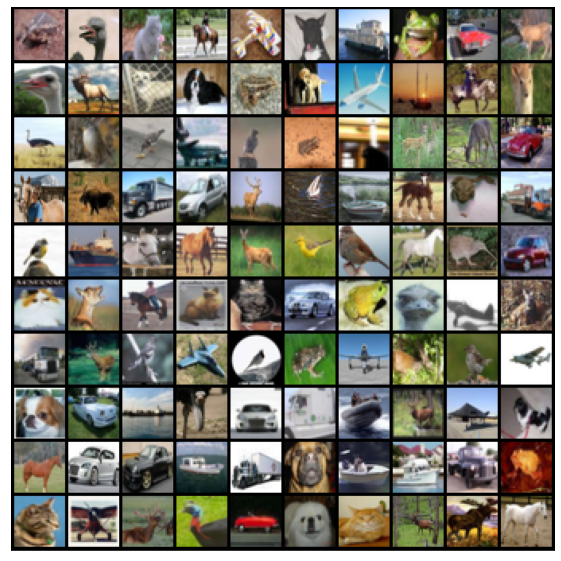

In [17]:
show_batch(train_dl)

## Defining the model

In our [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn), we defined a deep neural network with fully-connected layers using `nn.Linear`. For this tutorial however, we will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">


Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise. 

Checking out the following articles to gain a better understanding of convolutions:

1. [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) by Irhum Shafkat
2. [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) by Sylvian Gugger (this article implements convolutions from scratch)

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8, kernel_size = 3, stride=1, padding=1),
    nn.MaxPool2d(2,2)
)

In [20]:
for images, labels in train_dl:
  print('images.shape: ', images.shape)
  out = simple_model(images)
  print('out.shape: ', out.shape)
  break

# not an rgb channel, but a feature map 
# instead of color, edge, curve, gradient, shade...

images.shape:  torch.Size([100, 3, 32, 32])
out.shape:  torch.Size([100, 8, 16, 16])


The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [21]:
model = nn.Sequential(
    #input is 3x32x32
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # output is batch_sizex16x16x16 (16 features(out_channel))
    # maxpool2d reduces 32x32 to 16x16

    nn.Conv2d(16,16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # output is batch_sizex16x8x8 

    nn.Conv2d(16,16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # output is batch_sizex16x4x4 

    nn.Conv2d(16,16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # output is batch_sizex16x2x2 

    nn.Conv2d(16,16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # output is batch_sizex16x1x1 

    nn.Flatten(), # output is batch_sizex16
    nn.Linear(16,10) # output is batch_sizex10
)

In [22]:
print(model)
print(model[3].weight.shape)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten()
  (16): Linear(in_features=16, out_features=10, bias=True)
)
torch.Size([16, 16, 3, 3])


In [23]:
for images, labels in train_dl:
  print('images.shape: ', images.shape)
  out = model(images)
  print('out.shape: ', out.shape)
  print('out[0]: ',out[0])
  probs = F.softmax(out[0])
  print('Probabilities: ', probs)
  decision =  int(torch.max(probs).item())
  print('Decided: ',dataset.classes[decision])
  break

images.shape:  torch.Size([100, 3, 32, 32])
out.shape:  torch.Size([100, 10])
out[0]:  tensor([-0.0135,  0.2417, -0.1141,  0.0432,  0.0899, -0.1491,  0.0617,  0.1074,
         0.2473, -0.2633], grad_fn=<SelectBackward>)
Probabilities:  tensor([0.0951, 0.1227, 0.0860, 0.1006, 0.1054, 0.0830, 0.1025, 0.1073, 0.1234,
        0.0741], grad_fn=<SoftmaxBackward>)
Decided:  airplane


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Label: automobile


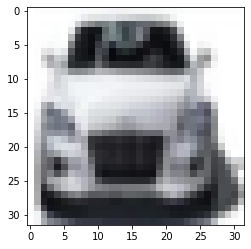

In [24]:
show_example(images[0], labels[0])

In [27]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  '''Move tensor(s) to chosen device'''
  if isinstance(data, (list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    '''Yield a batch of data after moving it to device'''
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    '''Number of batches'''
    return len(self.dl)


In [28]:
device = get_default_device()
print(device)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model,device)

cuda


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten()
  (16): Linear(in_features=16, out_features=10, bias=True)
)

In [30]:
def loss_batch(model, loss_func, xb, yb, opt = None, metric = None):
  # Generate Predictions
  preds = model(xb)
  # Calculate the loss
  loss = loss_func(preds, yb)

  if opt:
    # Calculate gradient
    loss.backward()
    # Update parameters
    opt.step()
    # Reset gradients
    opt.zero_grad()

  metric_result = None
  if metric:
    # Compute the metric
    metric_result = metric(preds, yb)

  return loss.item(), len(xb), metric_result

In [31]:
def evaluate(model, loss_fn, valid_dl, metric=None):
  with torch.no_grad():
    results = [loss_batch(model, loss_fn, xb, yb, metric = metric) \
               for xb, yb in valid_dl]
    losses, nums, metrics = zip(*results)
    # Total size of the dataset
    total = np.sum(nums)
    avg_loss = np.sum(np.multiply(losses, nums)) / total
    avg_metric = None
    if metric:
      avg_metric = np.sum(np.multiply(metrics, nums)) / total
  return avg_loss, total, avg_metric

In [46]:
def fit(epochs, model, loss_fn, train_dl, valid_dl,
        opt_fn = torch.optim.SGD, lr = None, metric = None):
  train_losses, val_losses, val_metrics = [], [], []

  # Instantiate the optimizer 
  opt = opt_fn(model.parameters(), lr =lr)

  for epoch in range(epochs):
    # Train
    model.train() # Are you training or evalutating 
    for xb, yb in train_dl:
      train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt, metric)

    # Evaluate 
    model.eval()
    val_loss, total, val_metric = evaluate(model, loss_fn, valid_dl, metric)

    # Record the loss & metric
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_metrics.append(val_metric)

    # Print progress
    if metric:
      print('Epoch: [{}/{}], train_loss: {:.4f}, valid_loss: {:.4f}, {}:{:.4f}'\
            .format(epoch+1, epochs, train_loss, val_loss, \
                    metric.__name__, val_metric))
    else:
      print('Epoch: [{}/{}], train_loss: {:.4f}, valid_loss: {:.4f}'\
            .format(epoch+1, epochs, train_loss, val_loss))
      
  return train_losses, val_losses, val_metrics

In [35]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == labels).item() / len(preds)

In [39]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, 
                                val_dl, metric = accuracy)
print('valid_loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

valid_loss: 2.3150, Accuracy: 0.0955


1/10 chance

In [43]:
num_epochs = 10
loss_fn = F.cross_entropy
opt_fn = torch.optim.Adam
lr = 0.005

In [47]:
train_losses, val_losses, val_metrics = fit(num_epochs, model, loss_fn, 
                                            train_dl, val_dl, opt_fn, 
                                            lr, metric = accuracy)

Epoch: [1/10], train_loss: 1.4473, valid_loss: 1.4805, accuracy:0.4495
Epoch: [2/10], train_loss: 1.3652, valid_loss: 1.4256, accuracy:0.4787
Epoch: [3/10], train_loss: 1.5850, valid_loss: 1.3497, accuracy:0.4936
Epoch: [4/10], train_loss: 1.2787, valid_loss: 1.2871, accuracy:0.5288
Epoch: [5/10], train_loss: 1.3157, valid_loss: 1.3058, accuracy:0.5341
Epoch: [6/10], train_loss: 1.1881, valid_loss: 1.1957, accuracy:0.5643
Epoch: [7/10], train_loss: 1.3498, valid_loss: 1.2118, accuracy:0.5644
Epoch: [8/10], train_loss: 1.2511, valid_loss: 1.1931, accuracy:0.5680
Epoch: [9/10], train_loss: 1.2292, valid_loss: 1.1732, accuracy:0.5793
Epoch: [10/10], train_loss: 1.1782, valid_loss: 1.1535, accuracy:0.5849


In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(train_loss, validation_loss):
  plt.plot(train_loss, '-x', color = 'red', label = 'train_loss')
  plt.plot(validation_loss, '-o', color = 'blue', label = 'validation_loss')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs. No. of Epochs')
  plt.show()
  plt.close()

def plot_acc(validation_acc):
  plt.plot(validation_acc, color = 'green', label = 'validation_acc')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs. No. of Epochs')
  plt.show()
  plt.close()

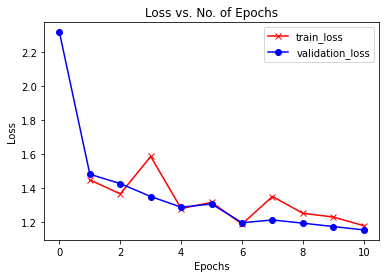

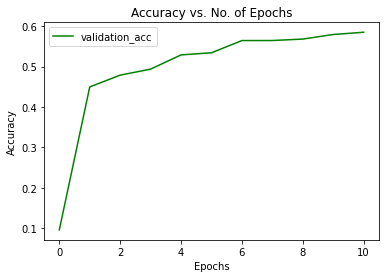

In [52]:
plot_loss([None]+train_losses, [val_loss]+val_losses)
plot_acc([val_acc] + val_metrics)

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point! 

<img src="https://i.stack.imgur.com/1QU0m.png" style="max-width:400px;">

This phenomenon is called **overfitting**, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.


Following are some common stragegies for avoiding overfitting:

- Gathering and generating more training data, or adding noise to it
- Using regularization techniques like batch normalization & dropout
- Early stopping of model's training, when validation loss starts to increase

We will cover these topics in more detail in the next tutorial in this series, and learn how we can reach an accuracy of **over 90%** by making minor but important changes to our model.

#!! 
To find a good learning rate, start with a smaller one, than increase it in the power of tens. Then look at the decreasing in the loss. If decrease in a great amount, than the learning rate is good.

In [54]:
test_dataset = ImageFolder(data_dir + '/test', transform =ToTensor())

In [55]:
def predict_image(img, model):
  # Convert to a batch of 1
  xb = img.unsqueeze(0)
  # Get predictions from model
  yb = model(xb.to(device))
  # Pick the index with highest probabiliy
  _,preds = torch.max(yb, dim=1)
  # Retrieve the class label
  return dataset.classes[preds[0].item()]

In [57]:
def test_model(index):
  img,label = test_dataset[index]
  plt.imshow(img.permute(1,2,0))
  print('Label:', dataset.classes[label], 'Predicted: ', predict_image(img,model))

Label: automobile Predicted:  truck


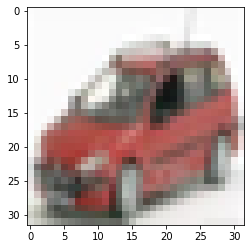

In [62]:
test_model(1236)

In [63]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size),device)
test_loss,_,test_acc = evaluate(model, F.cross_entropy, 
                                test_loader, metric = accuracy)
print('Loss : {:.4f}, Accuracy : {:.4f}'.format(test_loss, test_acc))

Loss : 1.1611, Accuracy : 0.5878


In [71]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [69]:
model2 = nn.Sequential(
    #input is 3x32x32
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # output is batch_sizex16x16x16 (16 features(out_channel))
    # maxpool2d reduces 32x32 to 16x16

    nn.Conv2d(16,16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # output is batch_sizex16x8x8 

    nn.Conv2d(16,16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # output is batch_sizex16x4x4 

    nn.Conv2d(16,16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # output is batch_sizex16x2x2 

    nn.Conv2d(16,16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    # output is batch_sizex16x1x1 

    nn.Flatten(), # output is batch_sizex16
    nn.Linear(16,10) # output is batch_sizex10
)

In [72]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [75]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size),device)
test_loss,_,test_acc = evaluate(to_device(model2,device), F.cross_entropy, 
                                test_loader, metric = accuracy)
print('Loss : {:.4f}, Accuracy : {:.4f}'.format(test_loss, test_acc))

Loss : 1.1611, Accuracy : 0.5878
